In [38]:
%load_ext autoreload
%autoreload 2



import sys, os
sys.path.append("../")

import numpy as np
import math
import pickle
from iotools.readOxford import ReadOxford
from iotools.readrpkm import ReadRPKM
from iotools.io_model import WriteModel
from inference.linreg_association import LinRegAssociation
from inference.empirical_bayes import EmpiricalBayes
from utils import hyperparameters
from inference import logmarglik
from iotools import readgtf
from utils import gtutils
from utils import mfunc
from utils.containers import ZstateInfo
from utils.printstamp import printStamp
from helper_functions import load_target_genes, write_params
from sklearn.preprocessing import scale

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prediction

In [39]:

from iotools.io_model import ReadModel
from utils.containers import GeneExpressionArray
from utils import gtutils
from utils import mfunc
from config import *

In [40]:


if not os.path.exists(p_pickfile):
# Read genotype (quite slow for testing) use pickle below
    p_oxf = ReadOxford(p_gtpath, p_samplepath, chrom, predicting_dataset)
    p_genotype = np.array(p_oxf.dosage)
    p_samplenames = p_oxf.samplenames
    p_snps = p_oxf.snps_info
    p_nsample = len(p_oxf.samplenames)

    printStamp("Dumping CHR {:d} genotype".format(chrom))
    with open(p_pickfile, 'wb') as output:
        pickle.dump(p_oxf, output, pickle.HIGHEST_PROTOCOL)
else:
    printStamp("Reading pickled genotype")
    with open(p_pickfile, 'rb') as input:
        pickled_oxf = pickle.load(input)

    printStamp("Done reading")

    p_genotype = np.array(pickled_oxf.dosage)
    p_samplenames = pickled_oxf.samplenames
    p_snps = pickled_oxf.snps_info
    p_nsample = len(pickled_oxf.samplenames)


2018-03-27 15:13:30 - Reading pickled genotype
2018-03-27 15:13:42 - Done reading


In [41]:
p_genotype.shape

(772027, 786)

In [59]:

# Use parameters from config.py
for p in parameters:
    prior = p[0]
    params = p[1]
    hyperpriors = p[2]
    hyperparams = p[3]
    run_description = p[4]
    model_dir = prior+"_{:.3f}_{:.3f}_{:.3f}_{:.3f}_{:.3f}".format(params[0], params[1], params[2], params[3], params[4])
    modelpath = os.path.join("./z"+str(zmax), run_description, model_dir)

    outfileprefix = os.path.join(modelpath,"cardio_pred_chr"+str(chrom))

    print(modelpath)

    printStamp("Predicting for "+model_dir)
    # Write predictions for each model
    p_model = ReadModel(modelpath, chrom)
    p_genes = p_model.genes
    gx = list()
    for gene in p_genes:

        trans_snps_file = os.path.join("cardiogenics_transqtls/gene_geno", "geno."+gene.ensembl_id.split(".")[0]+".snp.gz")
        if os.path.exists(trans_snps_file):
            print("Gene {:s} has transqtls!".format(gene.ensembl_id))
        else:
            print("No trans!")
            continue

        # Load trans-eQTLs for gene, if exists
        trans_oxf = ReadOxford(trans_snps_file, p_samplepath, chrom, predicting_dataset)
        trans_genotype = np.array(trans_oxf.dosage)
        trans_snps = trans_oxf.snps_info      
        
        newgenotype = np.concatenate( (p_genotype, trans_genotype), axis=0)
#         newgenotype = p_genotype
        newsnps = list(p_snps) + list(trans_snps)
        
        p_model.read_gene(gene)
        p_model_snps = p_model.snps
        p_model_zstates = p_model.zstates

        x = gtutils.prediction_variables(newsnps, p_model_snps, newgenotype)
        x = gtutils.normalize(p_model_snps, x)

        ypred = np.zeros(p_nsample)
        for z in p_model_zstates:
            ypred += z.prob * np.dot(x.T, z.exp)

        gx.append(GeneExpressionArray(geneid = gene.ensembl_id, expr_arr = ypred))


    # Write output
    mfunc.write_gcta_phenotype(outfileprefix, p_samplenames, gx)
    
    


./z1/trans_eQTLs_NoPriors/gxpred-bslmm_0.100_0.000_0.100_0.100_0.005
2018-03-27 15:41:51 - Predicting for gxpred-bslmm_0.100_0.000_0.100_0.100_0.005
Gene ENSG00000151065.9 has transqtls!
2018-03-27 15:41:51 - started reading genotype
Read 81 snps in 786 samples.
2018-03-27 15:41:51 - Finished readings snps
Found 295/295 SNPs for prediction
Found 295/295 SNPs for prediction
Gene ENSG00000078237.4 has transqtls!
2018-03-27 15:42:05 - started reading genotype
Read 156 snps in 786 samples.
2018-03-27 15:42:06 - Finished readings snps
Found 395/396 SNPs for prediction
Found 396/396 SNPs for prediction
Gene ENSG00000139194.3 has transqtls!
2018-03-27 15:42:24 - started reading genotype
Read 11 snps in 786 samples.
2018-03-27 15:42:24 - Finished readings snps
Found 215/216 SNPs for prediction
Found 216/216 SNPs for prediction
No trans!
No trans!
No trans!
Gene ENSG00000166527.3 has transqtls!
2018-03-27 15:42:38 - started reading genotype
Read 278 snps in 786 samples.
2018-03-27 15:42:38 - Fi

Found 230/231 SNPs for prediction
Found 231/231 SNPs for prediction
No trans!
No trans!
No trans!
Gene ENSG00000110917.3 has transqtls!
2018-03-27 15:51:52 - started reading genotype
Read 33 snps in 786 samples.
2018-03-27 15:51:52 - Finished readings snps
Found 236/236 SNPs for prediction
Found 236/236 SNPs for prediction
No trans!
No trans!
Gene ENSG00000139370.6 has transqtls!
2018-03-27 15:52:07 - started reading genotype
Read 43 snps in 786 samples.
2018-03-27 15:52:07 - Finished readings snps
Found 246/246 SNPs for prediction
Found 246/246 SNPs for prediction
Gene ENSG00000111450.9 has transqtls!
2018-03-27 15:52:16 - started reading genotype
Read 25 snps in 786 samples.
2018-03-27 15:52:16 - Finished readings snps
Found 236/236 SNPs for prediction
Found 236/236 SNPs for prediction


# Assessment 

In [60]:
import sys
sys.path.append("../")
import os
from iotools import readgtf
from iotools.readrpkm import ReadRPKM
from iotools.readPrediction import ReadPrediction
from scipy.stats import pearsonr
from helper_functions import load_target_genes, write_r2_dataframe, get_common_elements, new_write_predicted_r2, pearson_corr_rowwise
import math
import pickle
from utils.printstamp import printStamp

from config import *

In [61]:

# Load reference dataset Gene Expression
reference_rpkm = ReadRPKM(reference_expdatapath, "cardiogenics")
reference_expression = reference_rpkm.expression
reference_expr_donors = reference_rpkm.donor_ids
reference_gene_names = reference_rpkm.gene_names

In [62]:
gene_info = readgtf.gencode_v12(gtfpath, trim=False)

# use the selected_gene_ids with high R² values as targets, only those in the selected chrom will appear
selected_gene_ids = load_target_genes(genelistfile, gene_info, chrom)
target_genelist = [g.split(".")[0] for g in selected_gene_ids]
target_donors = reference_expr_donors


Read 641 genes with high r2 values

Found 57 genes in CHR 12


# Get R² on Cardiogenicsfor trans eQTL

In [63]:

from config import *


# Load reference dataset Gene Expression
reference_rpkm = ReadRPKM(reference_expdatapath, "cardiogenics")
reference_expression = reference_rpkm.expression
reference_expr_donors = reference_rpkm.donor_ids
reference_gene_names = reference_rpkm.gene_names


### GXpred assessment ###

for p in parameters:
    # p = parameters[0]
    prior = p[0]
    params = p[1]
    hyperpriors = p[2]
    hyperparams = p[3]
    run_description = p[4]
    model_dir = prior+"_{:.3f}_{:.3f}_{:.3f}_{:.3f}_{:.3f}".format(params[0], params[1], params[2], params[3], params[4])
    print(prior, params)

    modelpath = os.path.join("./z"+str(zmax), run_description, model_dir)

    gxpred = ReadPrediction(modelpath, p_samplepath, "gxpred", trim=True, prefix="cardio_pred_chr")

    # filter gxpred predicted values
    gxpred.sort_by_gene(target_genelist)
    gxpred.sort_by_samples(target_donors, use_prev=True)

    # Filter and sort the reference expression values

    sorted_expr_donors, ix_samples = get_common_elements(reference_expr_donors, gxpred.sorted_samples)
    sorted_gene_names, ix_genes = get_common_elements(reference_gene_names, gxpred.sorted_gene_names)
    sorted_expression = reference_expression[ix_genes,:][:, ix_samples].T

    # Calculate Pearson correlation
    gxpred_r = pearson_corr_rowwise(gxpred.sorted_expr_mat.T, sorted_expression.T)

    write_r2_dataframe(modelpath, chrom, prior, gxpred_r, gxpred)

gxpred-bslmm [0.1, 0.0, 0.1, 0.1, 0.005]
No prediction found for CHR 1
No prediction found for CHR 2
No prediction found for CHR 3
No prediction found for CHR 4
No prediction found for CHR 5
No prediction found for CHR 6
No prediction found for CHR 7
No prediction found for CHR 8
No prediction found for CHR 9
No prediction found for CHR 10
No prediction found for CHR 11
Loaded 39 genes in CHR 12
2
No prediction found for CHR 13
No prediction found for CHR 14
No prediction found for CHR 15
No prediction found for CHR 16
No prediction found for CHR 17
No prediction found for CHR 18
No prediction found for CHR 19
No prediction found for CHR 20
No prediction found for CHR 21
No prediction found for CHR 22
Genes found: 39 of 57
Samples found: 744 of 849
(786, 39)


/home/fsimone/myenv/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


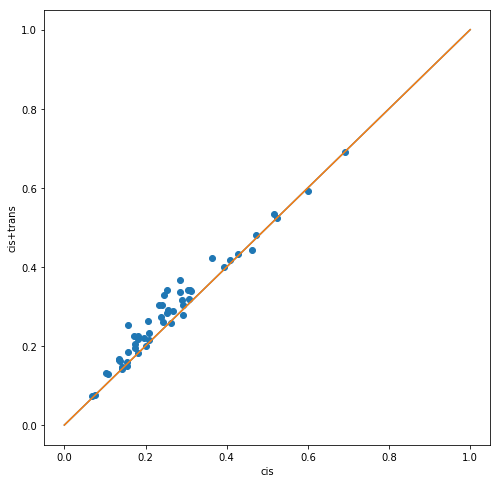

In [65]:
arr = np.loadtxt("anubhav_tmp", )

# with open("anubhav_tmp", 'r') as instream:
#     for line in instream:
#         line.strip().split()

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(arr[:,1], arr[:,0])
ax.plot([(0,0), (1,1)])
ax.set_xlabel("cis")
ax.set_ylabel("cis+trans")
fig.show()